# 16 - Pre-Prediction of GoodFit for Static Dataset

This notebook pre-computes GoodFit predictions by systematically varying protected attributes (age, sex, and race). The resulting static dataset enables the frontend to allow users to change one attribute at a time and explore potential bias—without needing to run predictions in real time.

In [35]:
import pandas as pd
import numpy as np
import pickle
import json
import random
import shap

import matplotlib.pyplot as plt

In [36]:
def load_feature_list(feature_list_path: str) -> list:
    """Load the feature list from a JSON file."""
    with open(feature_list_path, "r") as f:
        return json.load(f)

In [37]:
def sample_age(age_range_str: str) -> int:
    """
    Given a string age range (e.g., "20-30", "30-40", etc.),
    sample a random integer within that range. For ">60", sample between 61 and 80.
    """
    if "-" in age_range_str:
        min_age, max_age = map(int, age_range_str.split("-"))
        return random.randint(min_age, max_age)
    elif ">" in age_range_str:
        return random.randint(61, 80)
    else:
        raise ValueError("Invalid age range option.")

In [38]:
def predict_candidate_local(candidate_row: pd.Series, model, feature_list: list) -> dict:
    """Prepare candidate data, run model prediction, and compute top features using SHAP."""
    prepared_data = candidate_row[feature_list].to_frame().T
    # Ensure all values are numeric
    prepared_data = prepared_data.apply(pd.to_numeric, errors='coerce')
    # Prediction
    pred_proba = model.predict_proba(prepared_data)[:, 1][0]
    GoodFit = pred_proba >= 0.5
    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(prepared_data)
    feature_importance = pd.DataFrame({
        'Feature': prepared_data.columns,
        'SHAP Value': shap_values.values[0]
    }).sort_values(by='SHAP Value', ascending=False)
    top_features = feature_importance.head(3).to_dict(orient="records")
    return {
        "prediction_probability": pred_proba,
        "GoodFit": GoodFit,
        "top_features": top_features
    }

In [39]:
data_path = "../app/data/static_data.parquet"
model_path = "../models/xgb_model.pkl"
features_path = "../models/features.json"

In [40]:
df = pd.read_parquet(data_path)
feature_list = load_feature_list(features_path)
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [41]:
demographic_columns = ['Sex', 'RaceDesc_White', 'RaceDesc_Black or African American', 'RaceDesc_Asian', 'Age']
genders = ["Male", "Female"]

In [42]:
gender_map = {"Female": 0, "Male": 1}
age_options = ["20-30", "30-40", "40-50", "50-60", ">60"]
race_options = ["Black", "White", "Asian"]

In [43]:
results_list = []

# Loop over each candidate in the dataset
for idx, row in df.iterrows():
    # Predict for the original candidate profile
    original_pred = predict_candidate_local(row, model, feature_list)
    results_list.append({
        "Candidate_ID": row["Candidate_ID"],
        "Modified_Attribute": "None",
        "Original_Value": None,
        "New_Value": None,
        "Prediction_Probability": original_pred["prediction_probability"],
        "GoodFit": original_pred["GoodFit"],
        "Top_Features": original_pred["top_features"]
    })
    
    # --- Modify Gender ---
    original_gender = row["Sex"]  # encoded as 0 for Female, 1 for Male
    for gender in genders:
        if gender_map[gender] == original_gender:
            continue  # Skip if the candidate already has this gender
        modified_row = row.copy()
        modified_row["Sex"] = gender_map[gender]
        mod_pred = predict_candidate_local(modified_row, model, feature_list)
        results_list.append({
            "Candidate_ID": row["Candidate_ID"],
            "Modified_Attribute": "Sex",
            "Original_Value": "Female" if original_gender == 0 else "Male",
            "New_Value": gender,
            "Prediction_Probability": mod_pred["prediction_probability"],
            "GoodFit": mod_pred["GoodFit"],
            "Top_Features": mod_pred["top_features"]
        })
        
    # --- Modify Age ---
    original_age = row["Age"]
    for age_option in age_options:
        modified_row = row.copy()
        new_age = sample_age(age_option)
        modified_row["Age"] = new_age
        # Update the AgeGroup column as done in the backend
        if new_age < 30:
            modified_row["AgeGroup"] = "<30"
        elif 30 <= new_age <= 50:
            modified_row["AgeGroup"] = "30-50"
        else:
            modified_row["AgeGroup"] = ">50"
        mod_pred = predict_candidate_local(modified_row, model, feature_list)
        results_list.append({
            "Candidate_ID": row["Candidate_ID"],
            "Modified_Attribute": "Age",
            "Original_Value": original_age,
            "New_Value": new_age,
            "Prediction_Probability": mod_pred["prediction_probability"],
            "GoodFit": mod_pred["GoodFit"],
            "Top_Features": mod_pred["top_features"]
        })
        
    # --- Modify Race ---
    # For race, assume the dataset has binary indicators:
    # "RaceDesc_White", "RaceDesc_Black or African American", "RaceDesc_Asian"
    original_white = row["RaceDesc_White"]
    original_black = row["RaceDesc_Black or African American"]
    original_asian = row["RaceDesc_Asian"]
    for race in race_options:
        # Skip if candidate already has this race marked as 1
        if race == "White" and original_white == 1:
            continue
        if race == "Black" and original_black == 1:
            continue
        if race == "Asian" and original_asian == 1:
            continue
        modified_row = row.copy()
        # Set all race columns to 0 first, then update the selected one
        modified_row["RaceDesc_White"] = 0
        modified_row["RaceDesc_Black or African American"] = 0
        modified_row["RaceDesc_Asian"] = 0
        if race == "White":
            modified_row["RaceDesc_White"] = 1
        elif race == "Black":
            modified_row["RaceDesc_Black or African American"] = 1
        elif race == "Asian":
            modified_row["RaceDesc_Asian"] = 1
        mod_pred = predict_candidate_local(modified_row, model, feature_list)
        # Determine original race label
        if original_white == 1:
            orig_race = "White"
        elif original_black == 1:
            orig_race = "Black"
        elif original_asian == 1:
            orig_race = "Asian"
        else:
            orig_race = "Unknown"
        results_list.append({
            "Candidate_ID": row["Candidate_ID"],
            "Modified_Attribute": "Race",
            "Original_Value": orig_race,
            "New_Value": race,
            "Prediction_Probability": mod_pred["prediction_probability"],
            "GoodFit": mod_pred["GoodFit"],
            "Top_Features": mod_pred["top_features"]
        })

In [ ]:
results_df = pd.DataFrame(results_list)
# Convert problematic columns to string to ensure consistent types
results_df["Original_Value"] = results_df["Original_Value"].astype(str)
results_df["New_Value"] = results_df["New_Value"].astype(str)

In [45]:
results_df.head()

,Candidate_ID,Modified_Attribute,Original_Value,New_Value,Prediction_Probability,GoodFit,Top_Features
0,1,None,None,None,0.997927,True,"[{'Feature': 'RaceDesc_Asian', 'SHAP Value': 3..."
1,1,Sex,Female,Male,0.987788,True,"[{'Feature': 'RaceDesc_Asian', 'SHAP Value': 2..."
2,1,Age,50,26,0.999992,True,"[{'Feature': 'Age', 'SHAP Value': 3.3531455993..."
3,1,Age,50,30,0.999992,True,"[{'Feature': 'Age', 'SHAP Value': 3.3531455993..."
4,1,Age,50,48,0.999549,True,"[{'Feature': 'RaceDesc_Asian', 'SHAP Value': 3..."


In [46]:
# Ensure "None" values are correctly recognized as null
results_df["Modified_Attribute"] = results_df["Modified_Attribute"].replace("None", np.nan)

# Separate original and counterfactual predictions
original_preds = results_df[results_df["Modified_Attribute"].isnull()]
counterfactual_preds = results_df[results_df["Modified_Attribute"].notnull()]

# Merge the counterfactual rows with the corresponding original prediction,
# using the Candidate_ID.
merged = counterfactual_preds.merge(
    original_preds[["Candidate_ID", "Prediction_Probability"]],
    on="Candidate_ID",
    suffixes=("", "_original")
)

In [47]:
merged.head()

,Candidate_ID,Modified_Attribute,Original_Value,New_Value,Prediction_Probability,GoodFit,Top_Features,Prediction_Probability_original
0,1,Sex,Female,Male,0.987788,True,"[{'Feature': 'RaceDesc_Asian', 'SHAP Value': 2...",0.997927
1,1,Age,50,26,0.999992,True,"[{'Feature': 'Age', 'SHAP Value': 3.3531455993...",0.997927
2,1,Age,50,30,0.999992,True,"[{'Feature': 'Age', 'SHAP Value': 3.3531455993...",0.997927
3,1,Age,50,48,0.999549,True,"[{'Feature': 'RaceDesc_Asian', 'SHAP Value': 3...",0.997927
4,1,Age,50,59,0.999988,True,"[{'Feature': 'RaceDesc_Asian', 'SHAP Value': 3...",0.997927


In [48]:
# Calculate the difference in prediction probability
merged["Delta_Probability"] = merged["Prediction_Probability"] - merged["Prediction_Probability_original"]

# Display the relevant columns to inspect counterfactual effects
display(merged[["Candidate_ID", "Modified_Attribute", "Original_Value", "New_Value",
              "Prediction_Probability", "Prediction_Probability_original", "Delta_Probability"]].head(10))

,Candidate_ID,Modified_Attribute,Original_Value,New_Value,Prediction_Probability,Prediction_Probability_original,Delta_Probability
0,1,Sex,Female,Male,0.987788,0.997927,-0.010139
1,1,Age,50,26,0.999992,0.997927,0.002065
2,1,Age,50,30,0.999992,0.997927,0.002065
3,1,Age,50,48,0.999549,0.997927,0.001622
4,1,Age,50,59,0.999988,0.997927,0.002061
5,1,Age,50,66,1.000000,0.997927,0.002073
6,1,Race,Asian,Black,0.999694,0.997927,0.001767
7,1,Race,Asian,White,0.953388,0.997927,-0.044539
8,2,Sex,Male,Female,0.999951,0.999997,-0.000046
9,2,Age,42,29,1.000000,0.999997,0.000003


In [55]:
# Filter for candidates where Prediction_Probability crosses the 0.5 threshold
changed_candidates = merged[
    ((merged["Prediction_Probability_original"] < 0.5) & (merged["Prediction_Probability"] >= 0.5)) |
    ((merged["Prediction_Probability_original"] >= 0.5) & (merged["Prediction_Probability"] < 0.5))
]

# Get the unique Candidate_IDs where the status changed
changed_candidate_ids = changed_candidates["Candidate_ID"].unique()
print("Number of Candidate IDs with GoodFit status change:", len(changed_candidate_ids))

Number of Candidate IDs with GoodFit status change: 619


In [62]:
# Reduce results_df to only candidates with GoodFit status change
static_data = df[df["Candidate_ID"].isin(changed_candidate_ids)]

# Reduce merged (static predictions) to only relevant candidates
static_predictions = merged[merged["Candidate_ID"].isin(changed_candidate_ids)]

In [63]:
# Save to Parquet
static_data.to_parquet("../app/data/static_data.parquet", index=False)
print("Static dataset saved to ../app/data/static_data.parquet")

static_predictions.to_parquet("../app/data/static_predictions.parquet", index=False)
print("Static predictions saved to ../app/data/static_predictions.parquet")

Static dataset saved to ../app/data/static_data.parquet
Static predictions saved to ../app/data/static_predictions.parquet


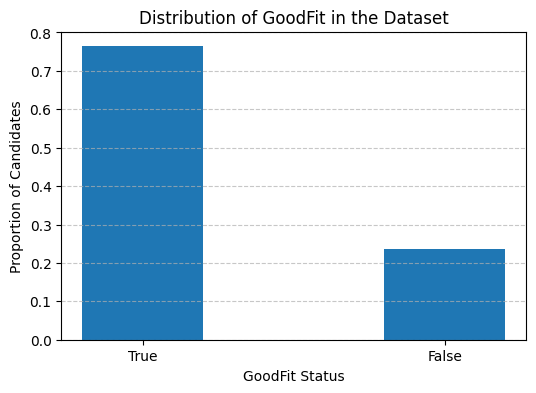

In [59]:
# Calculate the distribution of GoodFit in the dataset
goodfit_distribution = static_data["GoodFit"].value_counts(normalize=True)

# Plot the distribution
plt.figure(figsize=(6, 4))
plt.bar(goodfit_distribution.index.astype(str), goodfit_distribution.values, width=0.4)
plt.xlabel("GoodFit Status")
plt.ylabel("Proportion of Candidates")
plt.title("Distribution of GoodFit in the Dataset")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

TODO: Resample this?